In [1]:
cd ..

/Users/jibanmac/Documents/GitHub/gpy_dla_detection


In [2]:
from matplotlib import pyplot as plt
import h5py
import os
import time
import numpy as np

from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec
from gpy_dla_detection.civ_set_parameter import CIVParameters as Parameters
from gpy_dla_detection.civ_gp import CIVGPMAT
from astropy.io import fits


# GP model for constraining CIV parameters using MCMC

Read your data

In [3]:
plate: int = 349
mjd: int = 51699
fiber_id: int = 542
z_qso: float =  2.7348


# filename = "data/dr7q/spSpec-{}-{}-{}.fits".format(mjd, str(plate).zfill(4), str(fiber_id).zfill(3))

# if not os.path.exists(filename):
#     retrieve_raw_spec(plate, mjd, fiber_id)  # the spectrum at paper

# http://classic.sdss.org/dr7/dm/flatFiles/spSpec.html#spec
filename = "data/dr7q/spSpec-51699-0349-542.fit"

with fits.open(filename) as hdu:
    # Primary HDU image: spectrum, continuum-subtracted spectrum, noise in spectrum, mask array.
    data = hdu[0].data

    # coadded calibrated flux 10**-17 erg s**-1 cm**-2 A**-1
    flux = data[0, :]

    # noise variance
    noise_variance = data[2, :]**2

    # `and` mask
    and_mask = data[3, :]

    coeff0 = hdu[0].header["COEFF0"]
    coeff1 = hdu[0].header["COEFF1"]

    length = len(flux)

    # Λ = 10**(COEFF0 + COEFF1*i), where i denotes the (zero indexed) pixel number.
    wavelengths = 10**np.linspace(coeff0, coeff0 + coeff1*(length + 1), length)

    pixel_mask = (noise_variance == 0) | np.array(
        and_mask == int('0x800000', 16)
    ).astype("bool")



param = Parameters()

# wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

rest_wavelengths = param.emitted_wavelengths(wavelengths, z_qso)


In [5]:
# DLA GP Model
civ_gp = CIVGPMAT(
    param,
    3000.0,
    "data/dr7q/learned_model-C13_full.mat",
    True,
)
civ_gp.set_data(
    rest_wavelengths, flux, noise_variance, pixel_mask, z_qso, build_model=True
)

Text(0, 0.5, 'Flux [$10^{-17} erg/s/cm^2/\\AA$]')

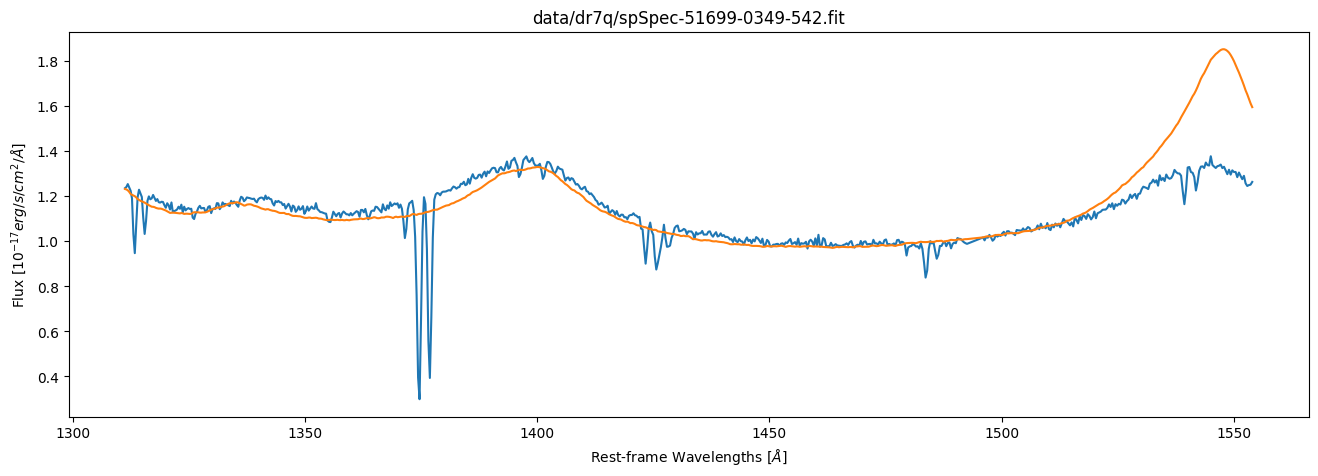

In [12]:
plt.figure(figsize=(16, 5))

plt.plot(civ_gp.x, civ_gp.y)
plt.plot(civ_gp.x, civ_gp.this_mu)

plt.title(filename)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Flux [$10^{-17} erg/s/cm^2/\AA$]")
